In [25]:
pip install torch


  Using cached sympy-1.14.0-py3-none-any.whl.metadata (12 kB)
  Using cached mpmath-1.3.0-py3-none-any.whl.metadata (8.6 kB)
   ---------------------------------------- 0.0/110.9 MB ? eta -:--:--
   ---------------------------------------- 0.3/110.9 MB ? eta -:--:--
    --------------------------------------- 1.6/110.9 MB 5.7 MB/s eta 0:00:20
   - -------------------------------------- 3.9/110.9 MB 8.3 MB/s eta 0:00:13
   -- ------------------------------------- 6.6/110.9 MB 9.4 MB/s eta 0:00:12
   --- ------------------------------------ 8.9/110.9 MB 9.9 MB/s eta 0:00:11
   --- ------------------------------------ 11.0/110.9 MB 10.2 MB/s eta 0:00:10
   ----- ---------------------------------- 13.9/110.9 MB 10.4 MB/s eta 0:00:10
   ----- ---------------------------------- 16.3/110.9 MB 10.6 MB/s eta 0:00:09
   ------ --------------------------------- 18.9/110.9 MB 10.7 MB/s eta 0:00:09
   ------- -------------------------------- 21.2/110.9 MB 10.8 MB/s eta 0:00:09
   -------- ---------

# PyTorch Intro: Tensors → Autograd Graph → nn.Module → Optimizers/Losses → Training Loop  

## Цели урока
К концу вы сможете:
- Создавать и менять **тензоры** (dtype, shape, device, indexing).
- Понимать **граф вычислений** и **autograd** (`requires_grad`, `.backward()`).
- Писать модель как **`nn.Module`** (слои, `forward`).
- Использовать **функции потерь** (`CrossEntropyLoss`, `BCEWithLogitsLoss`, `MSELoss`).
- Использовать **оптимизаторы** (`SGD`, `Adam`).
- Писать “скелет” тренировки: **Dataset → DataLoader → train/eval loop → сохранение модели**.

> Мы делаем мини-проект классификации на `make_moons` (2 класса).


In [26]:
# Если torch не установлен в вашей среде, установите заранее (в оффлайн-среде может не сработать).
# Обычно в Colab: !pip -q install torch torchvision torchaudio

import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

try:
    import torch
    import torch.nn as nn
    import torch.nn.functional as F
    from torch.utils.data import TensorDataset, DataLoader
except Exception as e:
    raise ImportError("PyTorch не найден. Установите torch перед уроком.") from e

from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

torch.manual_seed(42)
np.random.seed(42)

print("torch:", torch.__version__)
print("cuda available:", torch.cuda.is_available())

torch: 2.9.1+cpu
cuda available: False


# 1) Тензоры (Tensor)

В PyTorch **тензор** — это многомерный массив (как `numpy.ndarray`), но:
- может жить на **CPU** или **GPU** (`device`)
- может хранить **градиенты** (`requires_grad=True`)
- участвует в **графе вычислений** (autograd)

## Частые атрибуты
- `x.shape` (размерности)
- `x.dtype` (тип данных: float32, int64, ...)
- `x.device` (cpu/cuda)


In [27]:
# Создание тензоров
a = torch.tensor([1, 2, 3])                 # dtype обычно int64
b = torch.tensor([1.0, 2.0, 3.0])           # float32/float64 зависит от литералов
c = torch.zeros((2, 3))
d = torch.randn((2, 3))                     # нормальное распределение

print("a:", a, a.dtype)
print("b:", b, b.dtype)
print("c:", c.shape, c.dtype)
print("d:", d.shape, d.dtype)

# Преобразование numpy -> torch
x_np = np.array([[1.0, 2.0], [3.0, 4.0]], dtype=np.float32)
x = torch.from_numpy(x_np)                  # общий буфер памяти с numpy!
print("x:", x, x.dtype, x.shape)

a: tensor([1, 2, 3]) torch.int64
b: tensor([1., 2., 3.]) torch.float32
c: torch.Size([2, 3]) torch.float32
d: torch.Size([2, 3]) torch.float32
x: tensor([[1., 2.],
        [3., 4.]]) torch.float32 torch.Size([2, 2])


## 1.1) Shape, reshape, broadcast, indexing

- `view` / `reshape`: меняем форму (shape), не меняя данные
- broadcasting: как в numpy (сумма матрицы и вектора и т.д.)
- indexing: `x[rows, cols]`, срезы, маски


In [28]:
x = torch.arange(12).float()
print("x:", x)

X = x.view(3, 4)  # 3x4
print("X shape:", X.shape)
print(X)

# broadcasting: (3,4) + (4,)
v = torch.tensor([10, 20, 30, 40]).float()
Y = X + v
print("Y:", Y)

# indexing / slicing
print("row 0:", X[0])
print("col 1:", X[:, 1])
print("submatrix 0:2, 1:3:", X[0:2, 1:3])

# boolean mask
mask = X > 6
print("mask sum:", mask.sum().item())
print("values > 6:", X[mask])

x: tensor([ 0.,  1.,  2.,  3.,  4.,  5.,  6.,  7.,  8.,  9., 10., 11.])
X shape: torch.Size([3, 4])
tensor([[ 0.,  1.,  2.,  3.],
        [ 4.,  5.,  6.,  7.],
        [ 8.,  9., 10., 11.]])
Y: tensor([[10., 21., 32., 43.],
        [14., 25., 36., 47.],
        [18., 29., 40., 51.]])
row 0: tensor([0., 1., 2., 3.])
col 1: tensor([1., 5., 9.])
submatrix 0:2, 1:3: tensor([[1., 2.],
        [5., 6.]])
mask sum: 5
values > 6: tensor([ 7.,  8.,  9., 10., 11.])


## 1.2) Device (CPU/GPU)

- `device='cpu'` — всегда доступно
- `device='cuda'` — если есть GPU и установлен CUDA torch

Правило: **все тензоры, участвующие в операции, должны быть на одном устройстве**.


In [29]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

X = torch.randn(3, 4).to(device)
w = torch.randn(4).to(device)
y = X @ w
print("y device:", y.device, "shape:", y.shape)

device: cpu
y device: cpu shape: torch.Size([3])


# 2) Граф вычислений и autograd

PyTorch умеет автоматически считать производные (градиенты).  
Когда `requires_grad=True`, PyTorch строит **граф вычислений**:

- узлы: тензоры/операции
- ребра: зависимости
- `.backward()` запускает backprop и заполняет `.grad` у параметров

## Мини-пример
Функция: \( f(w) = (2w+1)^2 \).  
Найдём градиент df/dw автоматически.


In [30]:
w = torch.tensor(3.0, requires_grad=True)
f = (2*w + 1)**2
print("f:", f.item())

f.backward()  # df/dw
print("w.grad:", w.grad.item())

# Проверка вручную:
# f = (2w+1)^2 -> df/dw = 2*(2w+1)*2 = 4*(2w+1)
print("manual:", 4*(2*3.0 + 1))

f: 49.0
w.grad: 28.0
manual: 28.0


## 2.1) detach и no_grad

- `.detach()` — отцепить тензор от графа (градиенты не текут дальше)
- `with torch.no_grad():` — блок, в котором градиенты не считаются (ускоряет eval)

Это важно для:
- оценки модели на валидации/test
- сохранения предсказаний
- ускорения inference


In [31]:
w = torch.tensor(2.0, requires_grad=True)
z = w * 3
z_detached = z.detach()

print("z requires_grad:", z.requires_grad)
print("z_detached requires_grad:", z_detached.requires_grad)

# no_grad
with torch.no_grad():
    t = w * 10
print("t requires_grad:", t.requires_grad)

z requires_grad: True
z_detached requires_grad: False
t requires_grad: False


# 3) nn.Module: как строить нейросети

В PyTorch модель — это класс, наследующий **`nn.Module`**.

Главные элементы:
- слои объявляем в `__init__` (например, `nn.Linear`)
- вычисления описываем в `forward(self, x)`
- параметры автоматически доступны через `model.parameters()`

Сделаем простой MLP для бинарной классификации:
- вход 2 признака (x1, x2)
- скрытый слой 16 нейронов + ReLU
- выход 1 логит (число до sigmoid)


In [32]:
class MLPBinary(nn.Module):
    def __init__(self, n_in=2, n_hidden=16):
        super().__init__()
        self.fc1 = nn.Linear(n_in, n_hidden)
        self.fc2 = nn.Linear(n_hidden, 1)  # один логит

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)   # logits
        return x

model = MLPBinary(n_in=2, n_hidden=16)
print(model)

# Параметры
n_params = sum(p.numel() for p in model.parameters())
print("Total params:", n_params)

MLPBinary(
  (fc1): Linear(in_features=2, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=1, bias=True)
)
Total params: 65


# 4) Данные: TensorDataset + DataLoader

Мы возьмём `make_moons`:
- X: (n,2) float32
- y: (n,) 0/1

Для `BCEWithLogitsLoss`:
- logits: shape (n,1) float
- y: shape (n,1) float (0.0/1.0)

DataLoader делает батчи и перемешивание.


In [33]:
X, y = make_moons(n_samples=1200, noise=0.22, random_state=42)
X = X.astype(np.float32)
y = y.astype(np.float32).reshape(-1, 1)  # (n,1) float

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

# numpy -> torch tensors
X_train_t = torch.from_numpy(X_train)
y_train_t = torch.from_numpy(y_train)
X_test_t  = torch.from_numpy(X_test)
y_test_t  = torch.from_numpy(y_test)

train_ds = TensorDataset(X_train_t, y_train_t)
test_ds  = TensorDataset(X_test_t, y_test_t)

train_loader = DataLoader(train_ds, batch_size=64, shuffle=True)
test_loader  = DataLoader(test_ds, batch_size=256, shuffle=False)

print("Train batches:", len(train_loader), "Test batches:", len(test_loader))

Train batches: 15 Test batches: 2


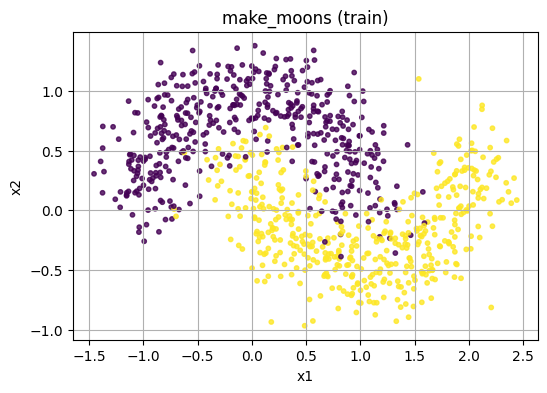

In [34]:
# Визуализация данных
plt.figure(figsize=(6,4))
plt.scatter(X_train[:,0], X_train[:,1], c=y_train.reshape(-1), s=10, alpha=0.8)
plt.title("make_moons (train)")
plt.xlabel("x1"); plt.ylabel("x2")
plt.grid(True)
plt.show()

# 5) Losses и Optimizers

## 5.1) BCEWithLogitsLoss
Для бинарной классификации самый удобный вариант:
- модель выдаёт **логиты** (без sigmoid)
- loss внутри сам применит sigmoid + log loss стабильным способом

## 5.2) Оптимизаторы
- `SGD(lr=...)` — базовый
- `Adam(lr=...)` — часто хорошо “из коробки”


In [35]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MLPBinary(n_in=2, n_hidden=16).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

print("device:", device)

device: cpu


# 6) Training loop (обучение)

Шаблон обучения в PyTorch:
1) `model.train()`
2) для каждого batch:
   - forward: logits = model(X)
   - loss = criterion(logits, y)
   - optimizer.zero_grad()
   - loss.backward()
   - optimizer.step()

Для оценки:
- `model.eval()`
- `torch.no_grad()`
- считаем метрики (accuracy, confusion matrix)

Важно: **logits → probability** через `torch.sigmoid(logits)`.


In [36]:
def train_one_epoch(model, loader, criterion, optimizer, device):
    model.train()
    total_loss = 0.0

    for Xb, yb in loader:
        Xb = Xb.to(device)
        yb = yb.to(device)

        logits = model(Xb)                 # (batch,1)
        loss = criterion(logits, yb)       # scalar

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        total_loss += loss.item() * Xb.size(0)

    return total_loss / len(loader.dataset)

@torch.no_grad()
def evaluate(model, loader, device, threshold=0.5):
    model.eval()
    all_probs = []
    all_true = []
    for Xb, yb in loader:
        Xb = Xb.to(device)
        logits = model(Xb)
        probs = torch.sigmoid(logits).cpu().numpy().reshape(-1)
        all_probs.append(probs)
        all_true.append(yb.numpy().reshape(-1))

    probs = np.concatenate(all_probs)
    y_true = np.concatenate(all_true).astype(int)
    y_pred = (probs >= threshold).astype(int)
    acc = accuracy_score(y_true, y_pred)
    cm = confusion_matrix(y_true, y_pred)
    return acc, cm, probs, y_true, y_pred

In [37]:
# Обучим 20 эпох
history = []
for epoch in range(1, 21):
    loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
    acc, cm, *_ = evaluate(model, test_loader, device, threshold=0.5)
    history.append((epoch, loss, acc))
    if epoch % 5 == 0:
        print(f"epoch={epoch:02d} loss={loss:.4f} test_acc={acc:.4f}")

hist_df = pd.DataFrame(history, columns=["epoch","loss","test_acc"])
hist_df.tail()

epoch=05 loss=0.3092 test_acc=0.8833
epoch=10 loss=0.2676 test_acc=0.8900
epoch=15 loss=0.2343 test_acc=0.9100
epoch=20 loss=0.1967 test_acc=0.9367


,epoch,loss,test_acc
15,16,0.224812,0.920000
16,17,0.216673,0.930000
17,18,0.210731,0.930000
18,19,0.205011,0.936667
19,20,0.196654,0.936667


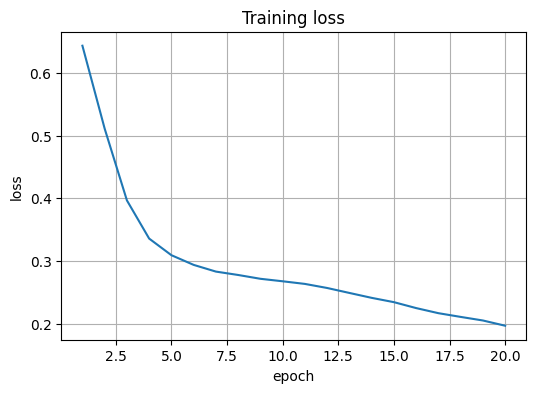

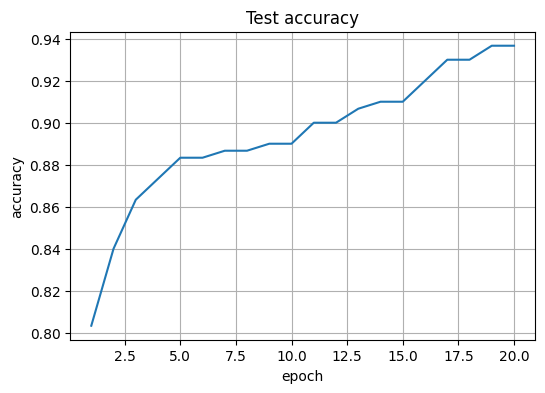

In [38]:
plt.figure(figsize=(6,4))
plt.plot(hist_df["epoch"], hist_df["loss"])
plt.title("Training loss")
plt.xlabel("epoch"); plt.ylabel("loss")
plt.grid(True); plt.show()

plt.figure(figsize=(6,4))
plt.plot(hist_df["epoch"], hist_df["test_acc"])
plt.title("Test accuracy")
plt.xlabel("epoch"); plt.ylabel("accuracy")
plt.grid(True); plt.show()

In [39]:
acc, cm, probs, y_true, y_pred = evaluate(model, test_loader, device, threshold=0.5)
print("Test acc:", acc)
print("Confusion matrix:\n", cm)

# Порог 0.5 vs другой
for thr in [0.3, 0.5, 0.7]:
    acc_thr, _, _, _, _ = evaluate(model, test_loader, device, threshold=thr)
    print(f"thr={thr}: acc={acc_thr:.4f}")

Test acc: 0.9366666666666666
Confusion matrix:
 [[141   9]
 [ 10 140]]
thr=0.3: acc=0.9233
thr=0.5: acc=0.9367
thr=0.7: acc=0.9133


# 7) Сохранение и загрузка модели

В PyTorch обычно сохраняют **`state_dict()`**:
- веса слоёв
- это компактно и удобно

При загрузке:
- создаём такую же архитектуру
- `load_state_dict`
- `model.eval()` для инференса


In [ ]:
MODEL_PATH = "/mlp_moons_binary_state_dict.pt"

torch.save(model.state_dict(), MODEL_PATH)
print("Saved:", MODEL_PATH)

# Создаём новую модель и загружаем веса
model2 = MLPBinary(n_in=2, n_hidden=16).to(device)
model2.load_state_dict(torch.load(MODEL_PATH, map_location=device))
model2.eval()

acc2, cm2, *_ = evaluate(model2, test_loader, device, threshold=0.5)
print("Loaded model acc:", acc2)
print("Loaded model CM:\n", cm2)

# 8) “Класс для тренировки” (Trainer)

Чтобы код не разрастался, часто делают класс Trainer:
- хранит model, optimizer, loss, device
- умеет `fit()` и `evaluate()`

Это не “обязательная магия”, а просто удобная упаковка.


In [ ]:
class Trainer:
    def __init__(self, model, criterion, optimizer, device):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device

    def train_one_epoch(self, loader):
        self.model.train()
        total_loss = 0.0

        for Xb, yb in loader:
            Xb = Xb.to(self.device)
            yb = yb.to(self.device)

            logits = self.model(Xb)
            loss = self.criterion(logits, yb)

            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()

            total_loss += loss.item() * Xb.size(0)

        return total_loss / len(loader.dataset)

    @torch.no_grad()
    def evaluate(self, loader, threshold=0.5):
        self.model.eval()
        all_probs, all_true = [], []
        for Xb, yb in loader:
            Xb = Xb.to(self.device)
            logits = self.model(Xb)
            probs = torch.sigmoid(logits).cpu().numpy().reshape(-1)
            all_probs.append(probs)
            all_true.append(yb.numpy().reshape(-1))
        probs = np.concatenate(all_probs)
        y_true = np.concatenate(all_true).astype(int)
        y_pred = (probs >= threshold).astype(int)
        acc = accuracy_score(y_true, y_pred)
        cm = confusion_matrix(y_true, y_pred)
        return acc, cm

# Мини-демо: обучим новую модель через Trainer (5 эпох)
model3 = MLPBinary(n_in=2, n_hidden=16).to(device)
trainer = Trainer(model3, nn.BCEWithLogitsLoss(), torch.optim.Adam(model3.parameters(), lr=0.01), device)

for epoch in range(1, 6):
    loss = trainer.train_one_epoch(train_loader)
    acc, _ = trainer.evaluate(test_loader)
    print(f"epoch={epoch} loss={loss:.4f} acc={acc:.4f}")

---
# 10 заданий (задание → подсказка → код с пропусками)

**Правило:** дополняйте пропуски `_____`. Код оставляйте “большим” — заполняйте несколько мест.


## Задание 1

**Задание:** Создайте тензор `x` из numpy массива `arr`, убедитесь что dtype float32 и shape (3,2).

**Подсказка:** `torch.from_numpy(arr).float()` и `reshape/view`


In [ ]:
import numpy as np, torch

arr = np.array([[1,2],[3,4],[5,6]], dtype=np.float32)
x = torch.from_numpy(arr).float()
x = x.reshape(3, 2)

print(x)
print("dtype:", x.dtype, "shape:", x.shape)

## Задание 2

**Задание:** Сделайте тензор на GPU (если доступно): X.to(device). Посчитайте y = X @ w.

**Подсказка:** `device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')`


In [42]:
import torch

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

X = torch.randn(3, 4)
w = torch.randn(4)

X = X.to(device)
w = w.to(device)

y = X @ w
print("y:", y, "device:", y.device)

y: tensor([-3.3368,  0.4553,  0.9051]) device: cpu


## Задание 3

**Задание:** Autograd: создайте w с requires_grad=True, посчитайте f=(2w+1)^2 и вызовите backward.

**Подсказка:** `w = torch.tensor(..., requires_grad=True)`; затем `f.backward()`


In [47]:
import torch

w = torch.tensor(3.0, requires_grad=True)
f = (2*w + 1)**2
print("f:", f.item())

f.backward()
print("grad:", w.grad)

f: 49.0
grad: tensor(28.)


## Задание 4

**Задание:** Покажите разницу: z_detached = z.detach() и with torch.no_grad().

**Подсказка:** у detached requires_grad=False; no_grad блок отключает граф внутри


In [48]:
import torch

w = torch.tensor(2.0, requires_grad=True)
z = w * 3

z_detached = z.detach()
print("z.requires_grad:", z.requires_grad)
print("z_detached.requires_grad:", z_detached.requires_grad)

with torch.no_grad():
    t = w * 10
print("t.requires_grad:", t.requires_grad)

z.requires_grad: True
z_detached.requires_grad: False
t.requires_grad: False


## Задание 5

**Задание:** Допишите класс MLPBinary: объявите два Linear слоя и forward с ReLU.

**Подсказка:** `self.fc1=nn.Linear(...); self.fc2=nn.Linear(...); forward: relu`


In [49]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class MLPBinaryStudent(nn.Module):
    def __init__(self, n_in=2, n_hidden=16):
        super().__init__()
        self.fc1 = nn.Linear(n_in, n_hidden)
        self.fc2 = nn.Linear(n_hidden, 1)

    def forward(self, x):
        x = self.fc1(x)
        x = F.relu(x)
        x = self.fc2(x)
        return x

m = MLPBinaryStudent()
print(m)

MLPBinaryStudent(
  (fc1): Linear(in_features=2, out_features=16, bias=True)
  (fc2): Linear(in_features=16, out_features=1, bias=True)
)


## Задание 6

**Задание:** Сделайте TensorDataset и DataLoader из X_train_t, y_train_t. batch_size=32, shuffle=True.

**Подсказка:** `train_ds = TensorDataset(X_train_t, y_train_t)`; `DataLoader(train_ds, ...)`


In [50]:
import torch
from torch.utils.data import TensorDataset, DataLoader

train_ds = TensorDataset(X_train_t, y_train_t)
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)

xb, yb = next(iter(train_loader))
print("xb shape:", xb.shape, "yb shape:", yb.shape)

xb shape: torch.Size([32, 2]) yb shape: torch.Size([32, 1])


## Задание 7

**Задание:** Соберите training step: logits=model(Xb), loss=criterion(logits,yb), backward+step.

**Подсказка:** optimizer.zero_grad(); loss.backward(); optimizer.step()


In [52]:
import torch
import torch.nn as nn

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

model = MLPBinary(n_in=2, n_hidden=16).to(device)
criterion = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

Xb, yb = next(iter(train_loader))
Xb = Xb.to(device)
yb = yb.to(device)

logits = model(Xb)
loss = criterion(logits, yb)

optimizer.zero_grad()
loss.backward()
optimizer.step()

print("loss:", loss.item())

loss: 0.7009870409965515


## Задание 8

**Задание:** Напишите evaluate: logits -> probs = sigmoid(logits), порог, accuracy.

**Подсказка:** `torch.sigmoid(logits)`; `with torch.no_grad()`; `accuracy_score`


In [54]:
import numpy as np
from sklearn.metrics import accuracy_score
import torch

@torch.no_grad()
def eval_student(model, loader, device, threshold=0.5):
    model.eval()
    all_probs, all_true = [], []
    for Xb, yb in loader:
        Xb = Xb.to(device)
        logits = model(Xb)
        probs = torch.sigmoid(logits).cpu().numpy().reshape(-1)
        all_probs.append(probs)
        all_true.append(yb.numpy().reshape(-1))
    probs = np.concatenate(all_probs)
    y_true = np.concatenate(all_true).astype(int)
    y_pred = (probs >= threshold).astype(int)
    return accuracy_score(y_true, y_pred)

print("acc:", eval_student(model, test_loader, device))

acc: 0.52


## Задание 9

**Задание:** Сохраните state_dict модели и загрузите в новую модель, сравните accuracy.

**Подсказка:** `torch.save(model.state_dict(), path)`; `load_state_dict(torch.load(...))`


In [59]:
import torch
import torch.nn as nn

path = "tmp_model.pt"
torch.save(model.state_dict(), path)

model_new = MLPBinary(n_in=2, n_hidden=16).to(device)
model_new.load_state_dict(torch.load(path, map_location=device))
model_new.eval()

acc_old = eval_student(model, test_loader, device)
acc_new = eval_student(model_new, test_loader, device)
print("acc old:", acc_old)
print("acc new:", acc_new)

acc old: 0.52
acc new: 0.52


## Задание 10

**Задание:** Сделайте мини-Trainer: метод fit на N эпох + evaluate. (Заполните пропуски)

**Подсказка:** Внутри fit: for epoch: train_one_epoch; затем evaluate


In [60]:
import torch
import torch.nn as nn

class TrainerStudent:
    def __init__(self, model, criterion, optimizer, device):
        self.model = model
        self.criterion = criterion
        self.optimizer = optimizer
        self.device = device

    def train_one_epoch(self, loader):
        self.model.train()
        total_loss = 0.0
        for Xb, yb in loader:
            Xb = Xb.to(self.device)
            yb = yb.to(self.device)
            logits = self.model(Xb)
            loss = self.criterion(logits, yb.view(-1,1).float())
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            total_loss += loss.item() * Xb.size(0)
        return total_loss / len(loader.dataset)

    @torch.no_grad()
    def evaluate(self, loader, thr=0.5):
        self.model.eval()
        correct = 0
        total = 0
        for Xb, yb in loader:
            Xb = Xb.to(self.device)
            logits = self.model(Xb)
            probs = torch.sigmoid(logits)
            pred = (probs >= thr).int().cpu().numpy().reshape(-1)
            true = yb.numpy().reshape(-1).astype(int)
            correct += (pred == true).sum()
            total += len(true)
        return correct / total

    def fit(self, train_loader, test_loader, epochs=5):
        for epoch in range(1, epochs+1):
            loss = self.train_one_epoch(train_loader)
            acc = self.evaluate(test_loader)
            print(f"epoch={epoch} loss={loss:.4f} acc={acc:.4f}")

model_s = MLPBinary(n_in=2, n_hidden=16).to(device)
trainer_s = TrainerStudent(model_s, nn.BCEWithLogitsLoss(), torch.optim.Adam(model_s.parameters(), lr=0.01), device)
trainer_s.fit(train_loader, test_loader, epochs=5)

epoch=1 loss=0.5580 acc=0.7967
epoch=2 loss=0.3667 acc=0.8700
epoch=3 loss=0.3101 acc=0.8833
epoch=4 loss=0.2861 acc=0.8900
epoch=5 loss=0.2733 acc=0.8933


---
## Короткий конспект (что запомнить)
- **Tensor** = данные + (опционально) градиенты + устройство (cpu/cuda)
- **Autograd** строит граф и считает `.grad` после `.backward()`
- **nn.Module** = слои в `__init__`, логика в `forward`
- **BCEWithLogitsLoss** принимает **логиты**, а не вероятности
- **Optimizer** делает шаг обновления параметров после `loss.backward()`
- **DataLoader** даёт батчи и shuffle
- Сохраняем обычно `state_dict()`
